In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import geeksw.hgcal.testbeam as hgc
import scipy
from scipy.optimize import curve_fit
from scipy.special import erf

In [2]:
h=list(hgc.runlist.query("Particle == 'electron'").groupby("Energy").mean().reset_index().Energy)
h

[20, 30, 50, 80, 100, 120, 150, 200, 250, 300]

In [3]:
def grindhammer(t, alpha, beta, E):
    return E * ((beta*t)**(alpha-1)*beta*np.exp(-beta*t)) / scipy.special.gamma(alpha)
def f(x, mu, sigma, N):
    return N * np.exp(-(x - mu)**2/(2*sigma**2))
def fitting(X0, energy):
    return curve_fit(grindhammer, X0, energy)

In [4]:
def gaus(x,mu, sigma, A ):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


def crystalball(x,n,a ,  xb, sig):
    x = x + 0j
    if a < 0:
        a = -a
    if n < 0:
        n = -n
    aa = abs(a)
    A = (n / aa) ** n * np.exp(-aa ** 2 / 2)
    B = n / aa - aa
    C = n / aa * 1 / (n - 1) * np.exp(-aa ** 2 / 2)
    D = np.sqrt(np.pi / 2) * (1 + erf(aa / np.sqrt(2)))
    N = 1.0 / (sig * (C + D))
    total = 0.0 * x
    total += ((x - xb) / sig > -a) * N * np.exp(-(x - xb) ** 2 / (2.0 * sig ** 2))
    total += ((x - xb) / sig <= -a) * N * A * (B - (x - xb) / sig) ** (-n)
    return total.real
    try:
        return total.real
    except:
        return total
    return total


def gausexp(x,  mu, sigma, N,k):
    if k < 0:
        k = -k

    total = 0.0 * x
    total += ((x - mu) / sigma > -k) * N * np.exp(-(x - mu) ** 2 / (2.0 * sigma ** 2))
    total += ((x - mu) / sigma <= -k) * N * np.exp(k ** 2 / 2.0 + k * ((x - mu) / sigma))

    return total

In [5]:
#electron_runlist = hgc.runlist.query("Energy == '250'").query("Particle == 'electron'")#.apply(lambda x : x.iloc[1,2,3,4])
#electron_runlist

In [23]:
query_number = list(hgc.runlist.query("Particle == 'electron'").query("Configuration == '22b'").groupby("Energy").mean().reset_index().Energy)
print (query_number)
resolution_mean = []
resolution_variance = []
for i in range(len(query_number)):
    h = int(query_number[i])
    electron_runlist = hgc.runlist.query(f"Energy == {h}").query("Particle == 'electron'").query("Configuration == '22b'")#.apply(lambda x : x.iloc[1,2,3,4])
    Resolution = []
    run_numbers = electron_runlist.Run.values[:2]
    for run in run_numbers:
        hdf = hgc.load_run(run, columns = ["beamEnergy","event", "rechit_layer", "rechit_energy", "rechit_X0", "rechit_dE"])
        rechit_energy_sum = hdf.groupby("event").rechit_energy.sum()
        rechit_energy_sum = rechit_energy_sum.reset_index()
        p = pd.DataFrame.quantile(rechit_energy_sum,[0.16,1.0])
        k1 = p.rechit_energy[0.16]
        k2 = p.rechit_energy[1.0]
        bins = np.linspace(k1, k2, 50)
        npoints, bin_edges = list(np.histogram(rechit_energy_sum.rechit_energy, bins=bins))
        bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
        bin_centers = bin_centers/np.median(bin_centers)
        npoints = npoints/np.sum(npoints)#0.2 [0.77, 0.016, 0.17, 1.12874385e-08]
        popt, pcov = curve_fit(gausexp, bin_centers, npoints, p0 = [0.85, 0.016, 0.17, 0.02], maxfev = 20000)#
        if popt[1]/popt[0]>0.1:
            popt, pcov = curve_fit(gausexp, bin_centers, npoints, p0 = [0.77, 0.016, 0.17, 1.12874385e-08], maxfev = 200000)
        Resolution.append(popt[1]/popt[0])
        print (len(Resolution))
        #print (popt)
    print (Resolution)
    res_mean = np.mean(np.abs(Resolution))
    res_variance = np.std(Resolution)
    resolution_mean = np.append(resolution_mean, res_mean)
    resolution_variance = np.append(resolution_variance, res_variance)
    #resolution_mean.append(res_mean)
    #res_variance.append(res_variance)
    print (h)

    

[20, 30, 50, 80, 100, 120, 150, 200, 250, 300]
1
2
[0.05124157872110611, 0.05613627816548983]
20
1
2
[0.047184871401137404, 0.0463756287361423]
30
1
2
[0.03814485789829977, -0.26595122353627876]
50
1
2
[0.03466033839647222, -0.03611095780767229]
80
1
2
[-0.028165173145523886, 0.028073337377025716]
100
1
2
[0.026876288716087653, 0.02498590453266187]
120
1
2
[0.024249292314215614, -0.027266531164751563]
150
1
2
[-0.0006768634274072481, -0.0066542470653354075]
200
1
2
[-0.046588718307864464, 0.017740586850239038]
250
1
2
[0.016131629306498245, 0.016750995487598244]
300


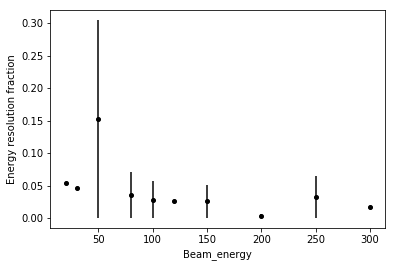

In [24]:
plt.errorbar(query_number, resolution_mean, yerr=resolution_variance, fmt='o', markersize=4, color='k')
plt.xlabel("Beam_energy")
plt.ylabel("Energy resolution fraction")
plt.show()

<ErrorbarContainer object of 3 artists>

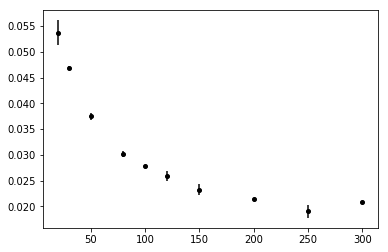

In [9]:
plt.errorbar(query_number, resolution_mean, yerr=resolution_variance, fmt='o', markersize=4, color='k')

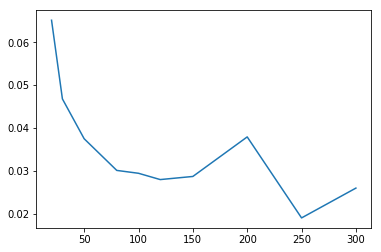

In [8]:
plt.plot(query_number, resolution_mean)

In [10]:
resolution_variance

array([0.03560829, 0.00139691, 0.00956196, 0.04576815, 0.01520897,
       0.00284454, 0.0049626 , 0.00799573, 0.0075756 , 0.0409652 ])

In [11]:
resolution_mean

array([0.04732287, 0.04658239, 0.03942737, 0.01908545, 0.0355248 ,
       0.02831338, 0.03137184, 0.03244985, 0.02391529, 0.01473165])

In [27]:
plt.errorbar(query_number, np.abs(resolution_mean), yerr=np.abs(resolution_variance, fmt='o', markersize=4, color='k')

SyntaxError: unexpected EOF while parsing (<ipython-input-27-c062052d010f>, line 1)

In [22]:
#run_numbers = electron_runlist.Run.values[:10]
#run_numbers

array([384, 385, 386, 389, 390, 391, 392, 393, 397, 398])

In [5]:
Resolution = []
run_numbers = electron_runlist.Run.values[:10]
for run in run_numbers:
    hdf = hgc.load_run(run, columns = ["beamEnergy","event", "rechit_layer", "rechit_energy", "rechit_X0", "rechit_dE"])
    rechit_energy_sum = hdf.groupby("event").rechit_energy.sum()
    rechit_energy_sum = rechit_energy_sum.reset_index()
    p = pd.DataFrame.quantile(rechit_energy_sum,[0.16,1.0])
    k1 = p.rechit_energy[0.16]
    k2 = p.rechit_energy[1.0]
    bins = np.linspace(k1, k2, 50)
    npoints, bin_edges = list(np.histogram(rechit_energy_sum.rechit_energy, bins=bins))
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
    bin_centers = bin_centers/np.median(bin_centers)
    npoints = npoints/np.sum(npoints)
    #popt, pcov = curve_fit(f, bin_centers, npoints, p0 = [22000,1000,300], maxfev = 20000)
    popt, pcov = curve_fit(gausexp, bin_centers, npoints, maxfev = 2000)#, p0 = [0.77, 0.02, 0.17, 0.20]
    print (popt)
    Resolution.append(popt[1]/popt[0])
    print (len(Resolution))

[0.7470814  0.01515818 0.18245261 0.1438458 ]
1
[ 0.93301785 -0.04428979  0.0552244   3.80619264]
2
[ 0.71819386 -0.03362055  0.17680969  3.72899849]
3
[0.7495951  0.01437144 0.18146976 0.13618177]
4
[0.7533551  0.01503063 0.1791988  0.14205082]
5
[1.02692091 0.01550928 0.03392685 0.09805214]
6
[1.07763752e+01 7.28381149e+00 2.03998052e-02 1.03978589e-08]
7
[1.09825472e+01 9.06466031e+00 2.04148815e-02 2.11827578e-07]
8
[ 1.10804649e+01  9.41712344e+00  2.04195065e-02 -2.15817566e-07]
9
[ 1.07673312e+01  6.84570112e+00  2.04026165e-02 -1.25332339e-07]
10


In [6]:
Resolution

[0.02028986692019114,
 -0.0474693930202513,
 -0.04681264556774179,
 0.019172273324647514,
 0.019951581192562778,
 0.015102705336843015,
 0.675905519453727,
 0.8253695705776395,
 0.8498852289298167,
 0.6357843897237814]

1
2
3
4
5
6
7
8
9
10


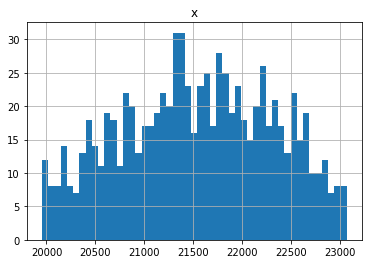

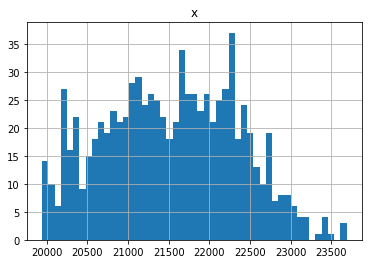

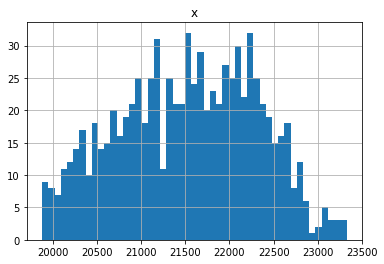

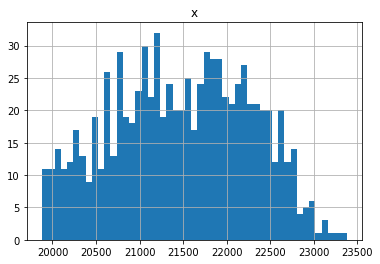

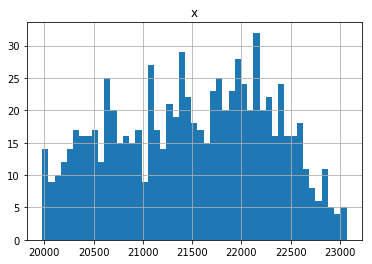

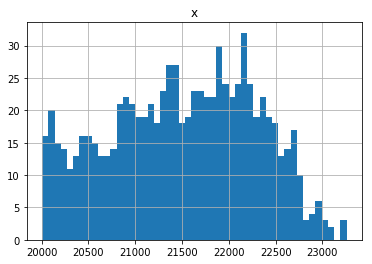

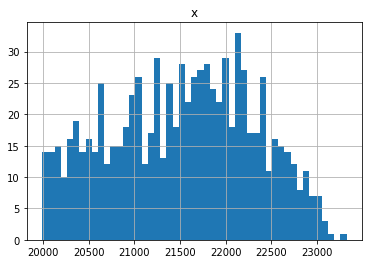

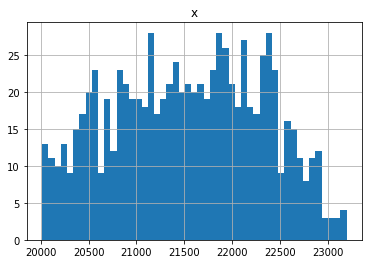

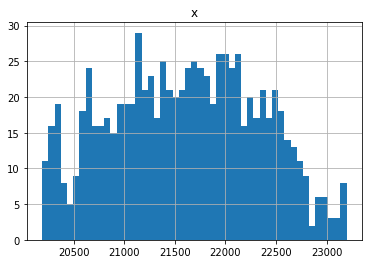

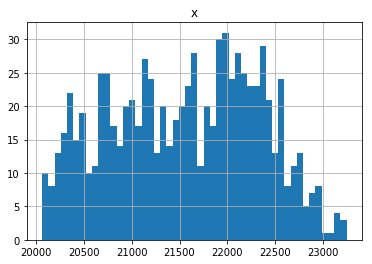

In [9]:
Resolution_2 = []
run_numbers = electron_runlist.Run.values[:10]
for run in run_numbers:
    hdf = hgc.load_run(run, columns = ["beamEnergy","event", "rechit_layer", "rechit_energy", "rechit_X0", "rechit_dE"])
    E = []
    p0 = [5.47, 0.5, 23000]
    for i in range(0,1000): 
        hdff = hdf.loc[i]
        hdff = hdff.groupby("rechit_X0").sum()
        hdff = hdff.reset_index()
        popt, pcov = curve_fit(grindhammer, hdff.rechit_X0, hdff.rechit_energy, p0, maxfev = 20000)
        E.append(popt[2])
    E = pd.DataFrame(data = dict(x=E))
    p = pd.DataFrame.quantile(E,[0.16,0.99])
    p1 = p.x[0.16]
    p2 = p.x[0.99]
    bins = np.linspace(p1, p2, 50)
    E.hist(bins=bins)
    npoints, bin_edges = list(np.histogram(E, bins=bins))
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
    popt, pcov = curve_fit(f, bin_centers, npoints, p0 = [22000,1000,300], maxfev = 20000)
    Resolution_2.append(popt[1]/popt[0])
    print (len(Resolution_2))


In [10]:
Resolution_2

[0.04945005721594409,
 0.047929781606112706,
 0.04479090888716153,
 0.04677893184941904,
 0.053182814329300915,
 0.047941979265107626,
 0.04812285075477356,
 0.050396834578624004,
 0.0448664182632021,
 0.05015769390264882]

In [ ]:
elif (0.88>popt[0]>0.83):
            popt, pcov = curve_fit(gausexp, bin_centers, npoints, p0 = [0.83, 0.016, 0.17, 1.12874385e-08], maxfev = 20000)
        elif (0.93>popt[0]>0.88):
            popt, pcov = curve_fit(gausexp, bin_centers, npoints, p0 = [0.88, 0.016, 0.17, 1.12874385e-08], maxfev = 20000)
        elif (0.98>popt[0]>0.93):
            popt, pcov = curve_fit(gausexp, bin_centers, npoints, p0 = [0.93, 0.016, 0.17, 1.12874385e-08], maxfev = 20000)
        elif (1.03>popt[0]>0.98):
            popt, pcov = curve_fit(gausexp, bin_centers, npoints, p0 = [0.98, 0.016, 0.17, 1.12874385e-08], maxfev = 20000)
        elif (popt[0]>1.03):
            popt, pcov = curve_fit(gausexp, bin_centers, npoints, p0 = [1.03, 0.016, 0.17, 1.12874385e-08], maxfev = 20000)